# Project: Train a Quadcopter How to Fly

Design an agent to fly a quadcopter, and then train it using a reinforcement learning algorithm of your choice! 

Try to apply the techniques you have learnt, but also feel free to come up with innovative ideas and test them.

## Instructions

Take a look at the files in the directory to better understand the structure of the project. 

- `task.py`: Define your task (environment) in this file.
- `agents/`: Folder containing reinforcement learning agents.
    - `policy_search.py`: A sample agent has been provided here.
    - `agent.py`: Develop your agent here.
- `physics_sim.py`: This file contains the simulator for the quadcopter.  **DO NOT MODIFY THIS FILE**.

For this project, you will define your own task in `task.py`.  Although we have provided a example task to get you started, you are encouraged to change it.  Later in this notebook, you will learn more about how to amend this file.

You will also design a reinforcement learning agent in `agent.py` to complete your chosen task.  

You are welcome to create any additional files to help you to organize your code.  For instance, you may find it useful to define a `model.py` file defining any needed neural network architectures.

## Controlling the Quadcopter

We provide a sample agent in the code cell below to show you how to use the sim to control the quadcopter.  This agent is even simpler than the sample agent that you'll examine (in `agents/policy_search.py`) later in this notebook!

The agent controls the quadcopter by setting the revolutions per second on each of its four rotors.  The provided agent in the `Basic_Agent` class below always selects a random action for each of the four rotors.  These four speeds are returned by the `act` method as a list of four floating-point numbers.  

For this project, the agent that you will implement in `agents/agent.py` will have a far more intelligent method for selecting actions!

In [16]:
%load_ext autoreload
%autoreload 2

import csv
import matplotlib.pyplot as plt
import numpy as np
import sys

# Modify the values below to give the quadcopter a different starting position.
runtime = 5.                                     # time limit of the episode
init_pose = np.array([0., 0., 10., 0., 0., 0.])  # initial pose
init_velocities = np.array([0., 0., 0.])         # initial velocities
init_angle_velocities = np.array([0., 0., 0.])   # initial angle velocities
file_output = 'data.txt'                         # file name for saved results

# Setup
labels = ['time', 'x', 'y', 'z', 'phi', 'theta', 'psi', 'x_velocity',
          'y_velocity', 'z_velocity', 'phi_velocity', 'theta_velocity',
          'psi_velocity', 'rotor_speed1', 'rotor_speed2', 'rotor_speed3', 'rotor_speed4']
results = {x : [] for x in labels}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [197]:
class FakeSim:
    pose = np.array([0., 0., 10.])
    done = False
    
class FakeTask:
    sim = FakeSim()
    target_pos =  np.array([0., 0., 50.])
    action_repeat = 3
    
faketask = FakeTask()

def plot_rewards(reward_function, start=0, end=100, zoom = 4):
    x = []
    y = []
    for i in range(0, 100):
        faketask.sim.pose[2] = i
        x.append(i)
        y.append(reward_function(faketask))
    plt.figure(figsize=(12, 6))
    plt.plot(x, y)
    mean = ((end - start) // 2)
    startzoom = mean - zoom
    endzoom = mean + zoom
    plt.figure(figsize=(12, 6))
    plt.plot(x[startzoom:endzoom], y[startzoom:endzoom])

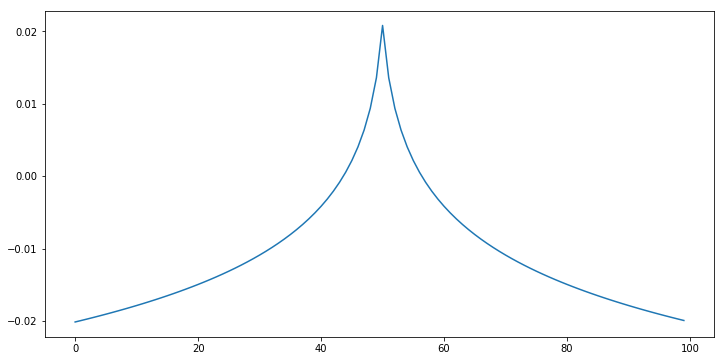

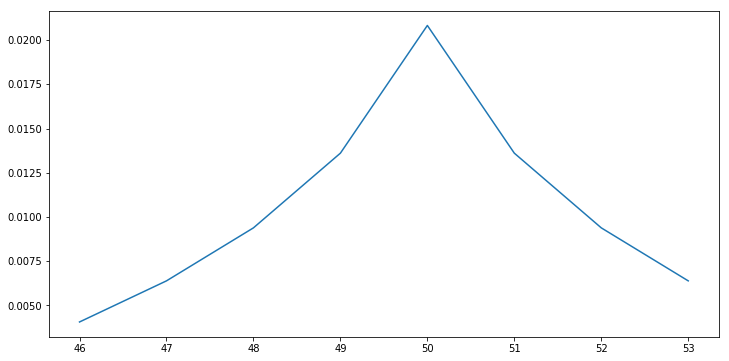

In [211]:
def reward_function(task, batch_size=32):
    if task.sim.done and task.sim.runtime > task.sim.time:
        return -1.
    reward = 2. - np.log(abs(task.sim.pose[2] - task.target_pos[2]) + 1.).sum()
    return reward / (batch_size * task.action_repeat)
plot_rewards(reward_function)

## Define the Task, Design the Agent, and Train Your Agent!

Amend `task.py` to specify a task of your choosing.  If you're unsure what kind of task to specify, you may like to teach your quadcopter to takeoff, hover in place, land softly, or reach a target pose.  

After specifying your task, use the sample agent in `agents/policy_search.py` as a template to define your own agent in `agents/agent.py`.  You can borrow whatever you need from the sample agent, including ideas on how you might modularize your code (using helper methods like `act()`, `learn()`, `reset_episode()`, etc.).

Note that it is **highly unlikely** that the first agent and task that you specify will learn well.  You will likely have to tweak various hyperparameters and the reward function for your task until you arrive at reasonably good behavior.

As you develop your agent, it's important to keep an eye on how it's performing. Use the code above as inspiration to build in a mechanism to log/save the total rewards obtained in each episode to file.  If the episode rewards are gradually increasing, this is an indication that your agent is learning.

In [223]:
from collections import defaultdict

from agents.agent import DDPG
from task import Task


ddpg_output = 'ddpgdata2.txt'
target_pos = np.array([0., 0., 50.])
task = Task(target_pos=target_pos)
agent = DDPG(task)
agent.tau = 0.01
agent.gamma = 0.99

resultados = {}
new_labels = labels + ['reward']
better_reward = float("-inf")
num_episodes = 200

with open(ddpg_output, 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(labels)
    for i_episode in range(1, num_episodes + 1):
        mean_reward = 0
        episode_reward = 0
        state = agent.reset_episode() # start a new episode
        episode_result = defaultdict(list)
        to_write_list = []
        while True:
            action = agent.act(state) 
            # print(action, task.sim.pose)
            next_state, reward, done = task.step(action,  reward_function)
            # print(reward)
            to_write = [task.sim.time] + list(task.sim.pose) + list(task.sim.v) \
                + list(task.sim.angular_v) + list(action) + [float(reward)]
            to_write_list.append(to_write)
            for ii in range(len(new_labels)):
                episode_result[new_labels[ii]].append(to_write[ii])
            agent.step(action, reward, next_state, done)
            state = next_state
            episode_reward += reward
            mean_reward = mean_reward + ((reward - mean_reward) / i_episode)
            if done:
                if reward > better_reward:
                    better_reward = reward
                sys.stdout.flush()
                print("\rReward {:0.04f} Better {:0.04f} Mean {:0.04f} Episode  {:0.04f} : {}   ".format(
                    reward, better_reward, mean_reward, episode_reward, i_episode), end="")
                break
        writer.writerows(to_write_list)
        resultados[i_episode] = episode_result


Reward -0.0294 Better 0.0516 Mean -0.0074 Episode  -1.9456 : 200    

## Plot the Rewards

Once you are satisfied with your performance, plot the episode rewards, either from a single run, or averaged over multiple runs. 

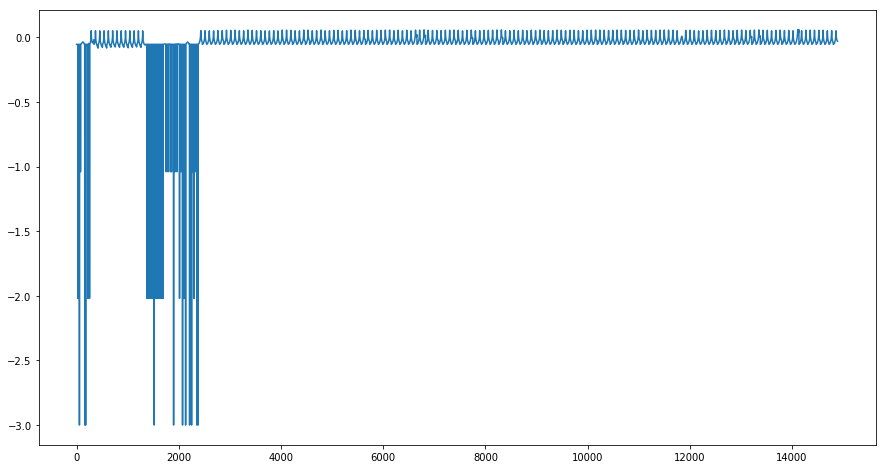

In [224]:
all_rewards = []
for e in range(1, num_episodes + 1):
    rewards = resultados[e]['reward']
    all_rewards.extend(rewards)
plt.figure(figsize=(15, 8))
plt.plot(all_rewards)
    

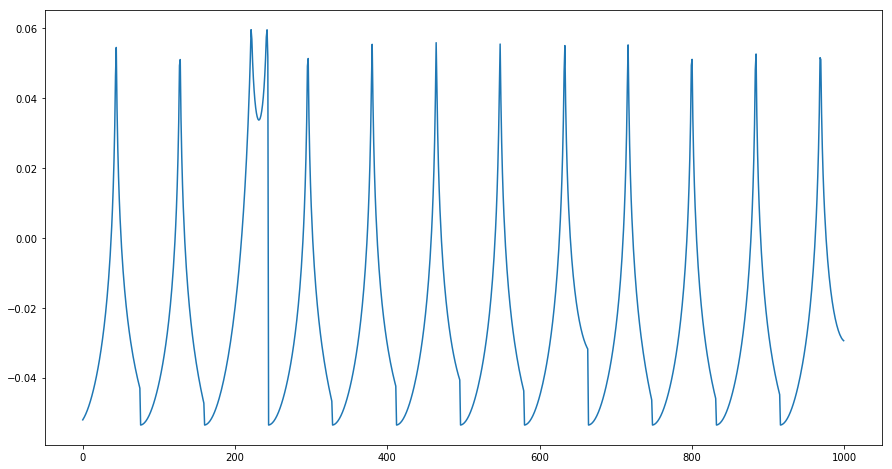

In [225]:
plt.figure(figsize=(15, 8))
plt.plot(all_rewards[-1000:])

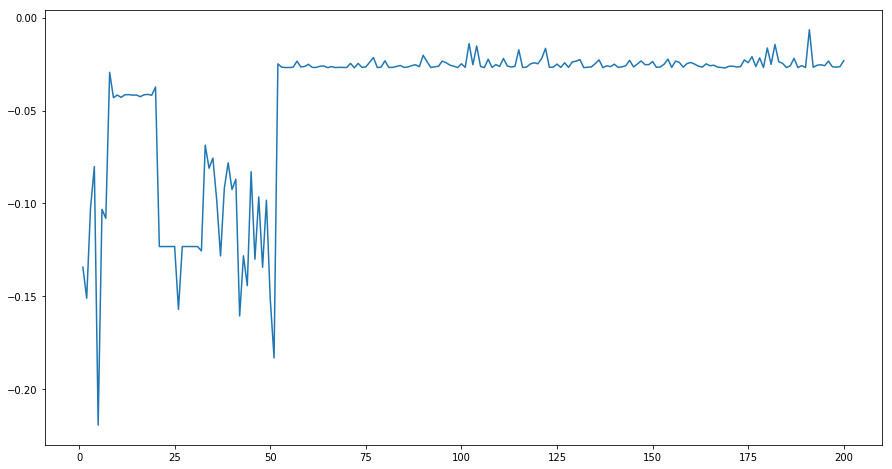

In [226]:
mean_rewards = []
nepisodes = []
for e in range(1, num_episodes + 1):
    rewards = resultados[e]['reward']
    mean_rewards.append(sum(rewards) / len(rewards))
    nepisodes.append(e)
plt.figure(figsize=(15, 8))
plt.plot(nepisodes, mean_rewards)
    

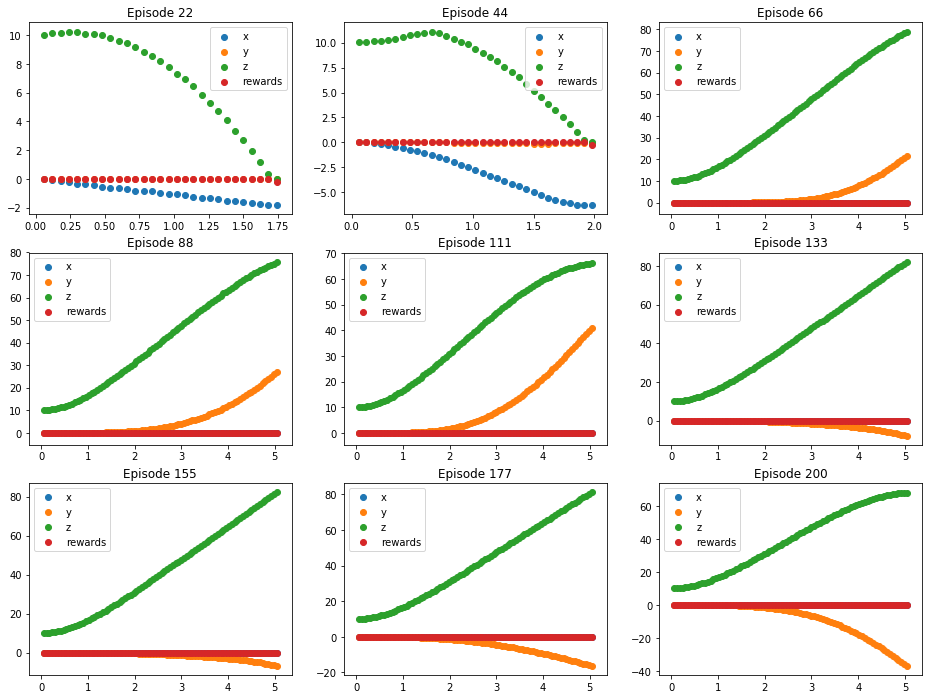

In [227]:
fig = plt.figure(figsize=(16, 12))
rows = cols = 3
num_plots = rows * cols
salto = num_episodes / num_plots

for i in range(num_plots):
    episode_number = int(salto  * (i + 1))
    results = resultados[episode_number]
    lrewards = [rw / 10 for rw in results['reward']]
    plt.subplot(rows, cols, i + 1)
    plt.scatter(results['time'], results['x'], label='x')
    plt.scatter(results['time'], results['y'], label='y')
    plt.scatter(results['time'], results['z'], label='z')
    plt.scatter(results['time'], lrewards, label='rewards')
    plt.legend()
    plt.title('Episode %s' % episode_number)
    _ = plt.ylim()

plt.show()

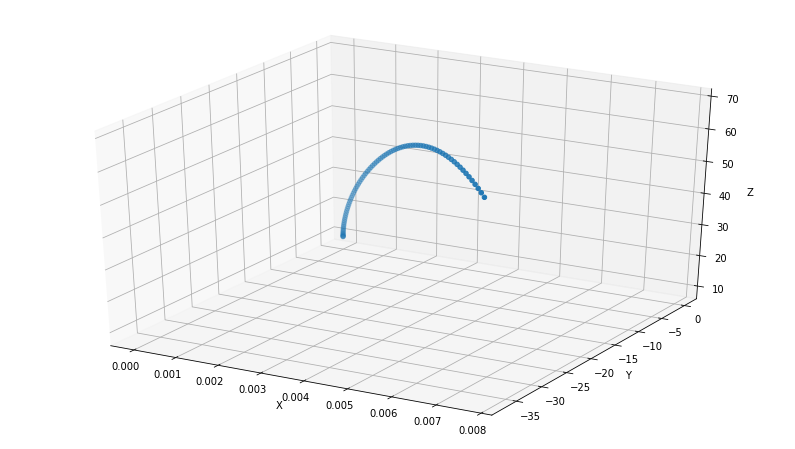

In [228]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline 

fig = plt.figure(figsize = (14,8))
ax = fig.add_subplot(111, projection='3d')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

results = resultados[num_episodes]
ax.scatter(results['x'], results['y'], results['z'])